<a href="https://colab.research.google.com/github/malofeevakate/mobile_games_project/blob/main/mobile_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm
from io import BytesIO
import requests
from scipy import stats

%matplotlib inline

In [15]:
# посмотрим на данные о регистрациях юзеров
df_reg = pd.read_csv('problem1-reg_data.csv', sep = ';')

In [16]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [17]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [18]:
# вытащим дату регистрации
df_reg['reg_datetime'] = pd.to_datetime(df_reg.reg_ts, unit = 's')
df_reg['reg_date'] = df_reg.reg_datetime.dt.date

In [19]:
df_reg.head()

,reg_ts,uid,reg_datetime,reg_date
0,911382223,1,1998-11-18 09:43:43,1998-11-18
1,932683089,2,1999-07-22 22:38:09,1999-07-22
2,947802447,3,2000-01-13 22:27:27,2000-01-13
3,959523541,4,2000-05-28 14:19:01,2000-05-28
4,969103313,5,2000-09-16 11:21:53,2000-09-16


In [20]:
print('min_date - ', df_reg.reg_date.min())
print('max_date - ', df_reg.reg_date.max())

min_date -  1998-11-18
max_date -  2020-09-23


In [21]:
df_reg.uid.nunique()

1000000

Имеющиеся данные содержат информацию о регистрации 1 млн юзеров игры за период с 18.11.1998 по 23.09.2020, то есть более чем за 20 лет

In [22]:
# сколько юзеров зарегилось в соответствующие даты
df_reg1 = df_reg.groupby('reg_date', as_index = False).agg({'uid' : 'nunique'})

In [23]:
df_reg1

,reg_date,uid
0,1998-11-18,1
1,1999-07-22,1
2,2000-01-13,1
3,2000-05-28,1
4,2000-09-16,1
...,...,...
5105,2020-09-19,1634
5106,2020-09-20,1636
5107,2020-09-21,1638
5108,2020-09-22,1641


<Axes: xlabel='reg_date', ylabel='uid'>

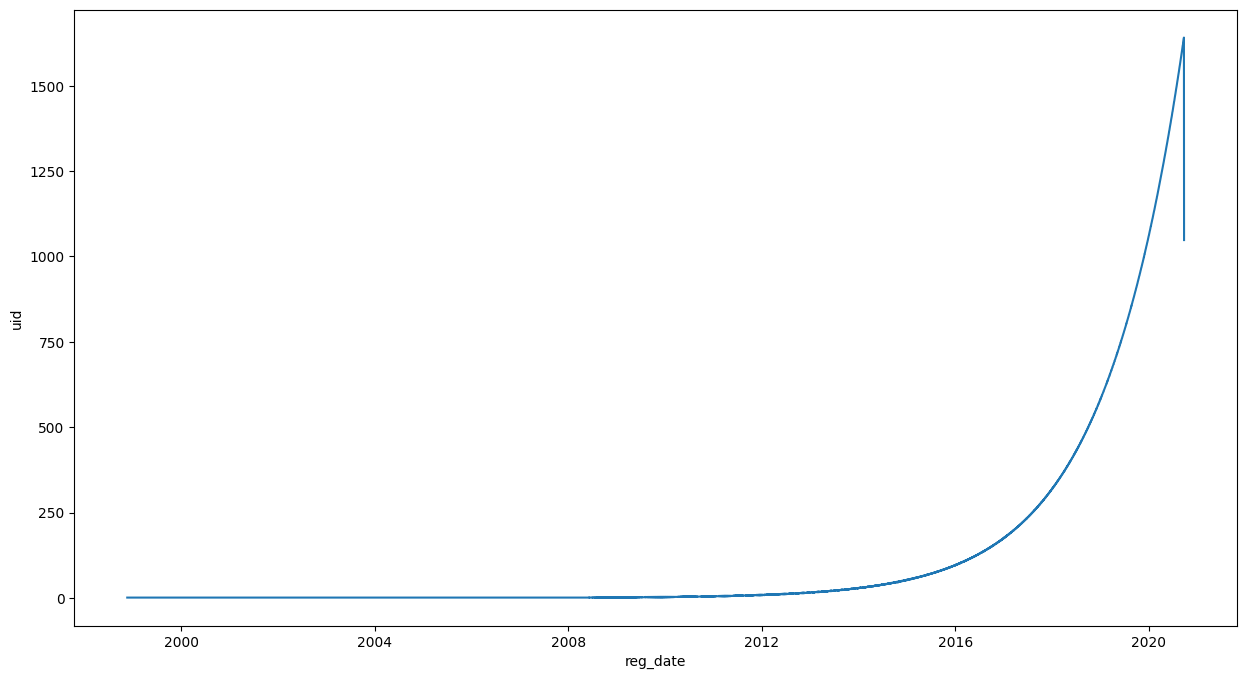

In [24]:
# до 2012 года регистраций немного, а потом какой-то всплеск активности к 2020 году
plt.figure(figsize=(15,8))
sns.lineplot(data=df_reg1, x = df_reg1.reg_date, y=df_reg1.uid)

In [43]:
# посмотрим на активности
df_act = pd.read_csv('problem1-auth_data.csv', sep = ';')

In [35]:
df_act.head()

,auth_ts,uid
0,911382223,1.0
1,932683089,2.0
2,932921206,2.0
3,933393015,2.0
4,933875379,2.0


In [44]:
df_act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [45]:
# вытащим дату активности в формате datetime
df_act['act_datetime'] = pd.to_datetime(df_act.auth_ts, unit = 's')
df_act['act_date'] = df_act.act_datetime.dt.date

In [29]:
df_act.head()

,auth_ts,uid,act_datetime,act_date
0,911382223,1,1998-11-18 09:43:43,1998-11-18
1,932683089,2,1999-07-22 22:38:09,1999-07-22
2,932921206,2,1999-07-25 16:46:46,1999-07-25
3,933393015,2,1999-07-31 03:50:15,1999-07-31
4,933875379,2,1999-08-05 17:49:39,1999-08-05


In [46]:
df_act.uid.nunique()

1000000

In [47]:
df = df_act.merge(df_reg[['uid', 'reg_date', 'reg_datetime']], how = 'left', on = 'uid')

In [32]:
df.head()

,auth_ts,uid,act_datetime,act_date,reg_date,reg_datetime
0,911382223,1,1998-11-18 09:43:43,1998-11-18,1998-11-18,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09,1999-07-22,1999-07-22,1999-07-22 22:38:09
2,932921206,2,1999-07-25 16:46:46,1999-07-25,1999-07-22,1999-07-22 22:38:09
3,933393015,2,1999-07-31 03:50:15,1999-07-31,1999-07-22,1999-07-22 22:38:09
4,933875379,2,1999-08-05 17:49:39,1999-08-05,1999-07-22,1999-07-22 22:38:09


In [33]:
df.query('act_datetime != reg_datetime').uid.nunique()

87346

За более чем 20 лет из миллиона зарегистрировавшихся юзеров проявляли активность менее 25%  

Retention может рассчитываться двумя способами:  
    - по календарным дням,  
    - по 24 часовому окну  

## Оценим Retention по календарным дням

In [ ]:
def day_retention():
    # уточняем даты для расчета retention
    start_date = pd.to_datetime(input('Дата начала периода:'))
    end_date = pd.to_datetime(input('Дата окончания периода:'))

    #считываем и преобразуем данные по регистрациям
    df_reg = pd.read_csv('problem1-reg_data.csv', sep = ';')
    df_reg['reg_datetime'] = pd.to_datetime(df_reg.reg_ts, unit = 's')
    df_reg['reg_date'] = df_reg.reg_datetime.dt.date
    df_reg = df_reg.query('(reg_date >= @start_date) & (reg_date <= @end_date)')

    #считываем и преобразуем данные по активностям
    df_act = pd.read_csv('problem1-auth_data.csv', sep = ';')
    df_act['act_datetime'] = pd.to_datetime(df_act.auth_ts, unit = 's')
    df_act['act_date'] = df_act.act_datetime.dt.date
    df_act = df_act.query('(act_date >= @start_date) & (act_date <= @end_date)')

    # мерджим полученные фреймы
    df = df_act.merge(df_reg[['uid', 'reg_date', 'reg_datetime']], how = 'left', on = 'uid')
    df.dropna(inplace = True)
    # считаем для каждой активности число дней с момента регистрации
    df['period'] = (df.act_date - df.reg_date).dt.days
    # считаем для каждой даты регистрации активных юзеров в каждом периоде
    df_active_users = df.groupby(['reg_date', 'period'], as_index = False) \
    .agg({'uid' : 'nunique'}) \
    .rename(columns = {'uid' : 'active_users_count'})
    # для каждой даты регистрации считаем число уникальных юзеров
    df_reg_users = df.groupby('reg_date', as_index = False) \
    .agg({'uid' : 'nunique'}) \
    .rename(columns = {'uid' : 'reg_users_count'})
    # готовим итоговую таблицу для расчета Retention и считаем его
    df_result = df_active_users.merge(df_reg_users, how = 'left', on = 'reg_date')
    df_result['retention'] = (df_result.active_users_count *100 / df_result.reg_users_count)
    df_result.retention = df_result.retention.apply(lambda x: round(x,2))

    return df_result

In [ ]:
def day_retention_lineplot(df_result):
    # уточняем дату / когорту для построения графика retention
    ret_date = pd.to_datetime(input('Дата когорты:'))
    # готовим данные
    df_result = df_result.query('reg_date == @ret_date')

    # настройки итогового графика
    plt.figure(figsize=(15,10))
    fig = sns.lineplot(x=df_result.period[1:], y=df_result.retention[1:])
    return fig

In [ ]:
df_result = day_retention()
pivot = df_result.pivot_table(index = 'reg_date', columns = 'period', values = 'retention').fillna('')
pivot

Дата начала периода:20/06/2020


C:\Users\User\AppData\Local\Temp\ipykernel_6804\1688734656.py:3: UserWarning: Parsing '20/06/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  start_date = pd.to_datetime(input('Дата начала периода:'))


Дата окончания периода:27/06/2020


C:\Users\User\AppData\Local\Temp\ipykernel_6804\1688734656.py:4: UserWarning: Parsing '27/06/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  end_date = pd.to_datetime(input('Дата окончания периода:'))
C:\Users\User\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\User\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op

period,0,1,2,3,4,5,6,7
reg_date,,,,,,,,
2020-06-20,100.0,2.35,3.91,5.33,6.4,7.04,8.39,6.26
2020-06-21,100.0,2.56,4.05,4.47,4.83,6.1,6.53,
2020-06-22,100.0,2.06,5.25,4.96,5.11,5.53,,
2020-06-23,100.0,2.26,4.1,4.81,5.8,,,
2020-06-24,100.0,1.98,4.38,4.88,,,,
2020-06-25,100.0,1.76,3.74,,,,,
2020-06-26,100.0,2.46,,,,,,
2020-06-27,100.0,,,,,,,


Дата когорты:20/06/2020


C:\Users\User\AppData\Local\Temp\ipykernel_6804\2692480065.py:3: UserWarning: Parsing '20/06/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  ret_date = pd.to_datetime(input('Дата когорты:'))
C:\Users\User\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


<AxesSubplot:xlabel='period', ylabel='retention'>

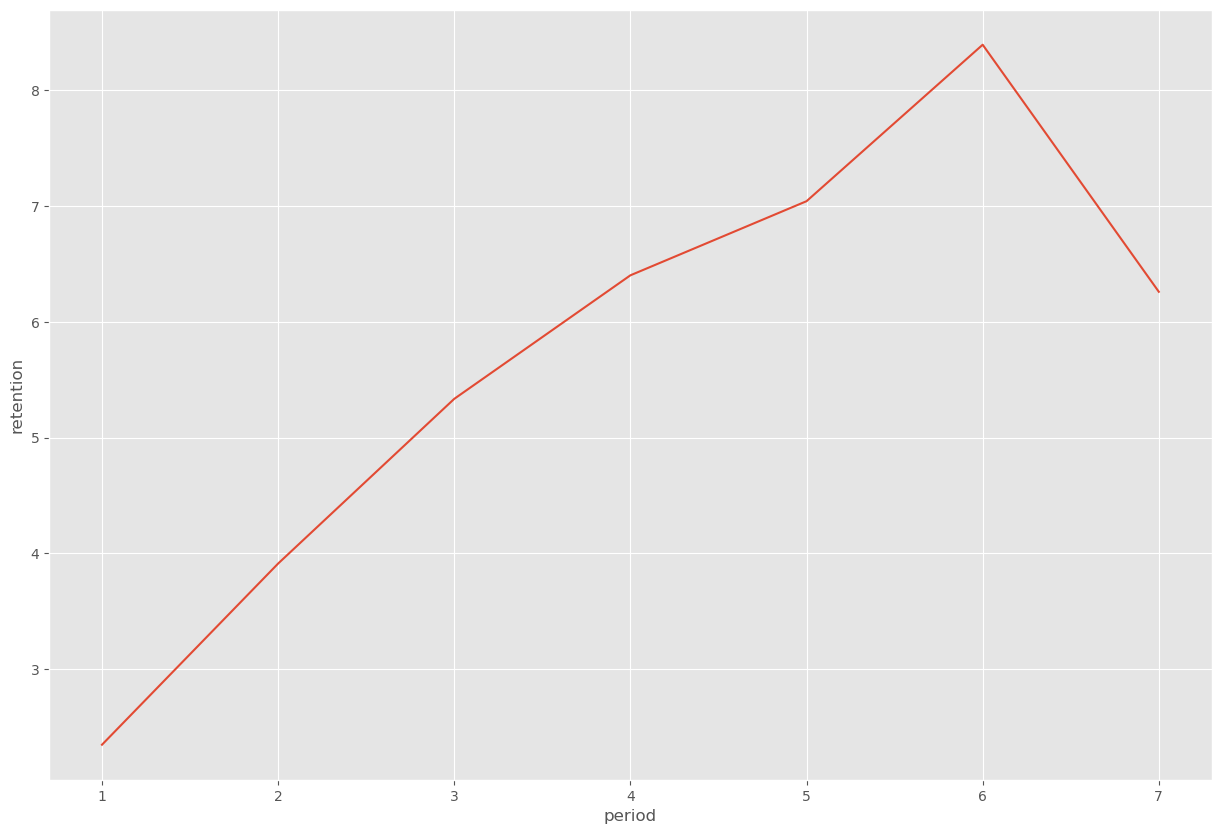

In [ ]:
day_retention_lineplot(df_result)

## Оценим Retention по 24-часовым окнам

In [ ]:
def window_retention():
    # уточняем даты для расчета retention
    start_date = pd.to_datetime(input('Дата начала периода:'))
    end_date = pd.to_datetime(input('Дата окончания периода:'))

    #считываем и преобразуем данные по регистрациям
    df_reg = pd.read_csv('problem1-reg_data.csv', sep = ';')
    df_reg['reg_datetime'] = pd.to_datetime(df_reg.reg_ts, unit = 's')
    df_reg['reg_date'] = df_reg.reg_datetime.dt.date
    df_reg = df_reg.query('(reg_date >= @start_date) & (reg_date <= @end_date)')

    #считываем и преобразуем данные по активностям
    df_act = pd.read_csv('problem1-auth_data.csv', sep = ';')
    df_act['act_datetime'] = pd.to_datetime(df_act.auth_ts, unit = 's')
    df_act['act_date'] = df_act.act_datetime.dt.date
    df_act = df_act.query('(act_date >= @start_date) & (act_date <= @end_date)')

    # мерджим полученные фреймы
    df = df_act.merge(df_reg[['uid', 'reg_date', 'reg_datetime']], how = 'left', on = 'uid')
    df.dropna(inplace = True)
    # считаем для каждой активности число дней с момента регистрации
    df['period'] = (df.act_datetime - df.reg_datetime).dt.total_seconds() / 60 / 60 /24
    df.period = df.period.apply(np.floor)
    # считаем для каждой даты регистрации активных юзеров в каждом периоде
    df_active_users = df.groupby(['reg_date', 'period'], as_index = False) \
    .agg({'uid' : 'nunique'}) \
    .rename(columns = {'uid' : 'active_users_count'})
    # для каждой даты регистрации считаем число уникальных юзеров
    df_reg_users = df.groupby('reg_date', as_index = False) \
    .agg({'uid' : 'nunique'}) \
    .rename(columns = {'uid' : 'reg_users_count'})
    # готовим итоговую таблицу для расчета Retention и считаем его
    df_window_result = df_active_users.merge(df_reg_users, how = 'left', on = 'reg_date')
    df_window_result['retention'] = (df_window_result.active_users_count *100 / df_window_result.reg_users_count)
    df_window_result.retention = df_window_result.retention.apply(lambda x: round(x,2))

    return df_window_result

In [ ]:
def window_retention_lineplot(df_window_result):
    # уточняем дату / когорту для построения графика retention
    ret_window_date = pd.to_datetime(input('Дата когорты:'))
    # готовим данные
    df_window_result = df_window_result.query('reg_date == @ret_window_date')

    # настройки итогового графика
    plt.figure(figsize=(15,10))
    figw = sns.lineplot(x=df_window_result.period[1:], y=df_window_result.retention[1:])
    return figw

In [ ]:
df_window_result = window_retention()
pivotw = df_window_result.pivot_table(index = 'reg_date', columns = 'period', values = 'retention').fillna('')
pivotw

Дата начала периода:20/06/2020


C:\Users\User\AppData\Local\Temp\ipykernel_6804\1421701253.py:3: UserWarning: Parsing '20/06/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  start_date = pd.to_datetime(input('Дата начала периода:'))


Дата окончания периода:27/06/2020


C:\Users\User\AppData\Local\Temp\ipykernel_6804\1421701253.py:4: UserWarning: Parsing '27/06/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  end_date = pd.to_datetime(input('Дата окончания периода:'))
C:\Users\User\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\User\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op

period,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
reg_date,,,,,,,,
2020-06-20,100.0,4.34,4.69,5.12,7.68,7.04,8.46,2.35
2020-06-21,100.0,4.76,3.48,5.04,5.61,6.17,3.48,
2020-06-22,100.0,3.9,6.1,4.61,5.6,2.7,,
2020-06-23,100.0,4.38,4.31,5.59,2.69,,,
2020-06-24,100.0,3.82,5.3,2.12,,,,
2020-06-25,100.0,3.39,2.12,,,,,
2020-06-26,100.0,2.46,,,,,,
2020-06-27,100.0,,,,,,,


Дата когорты:20/06/2020


C:\Users\User\AppData\Local\Temp\ipykernel_6804\1538925922.py:3: UserWarning: Parsing '20/06/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  ret_window_date = pd.to_datetime(input('Дата когорты:'))
C:\Users\User\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


<AxesSubplot:xlabel='period', ylabel='retention'>

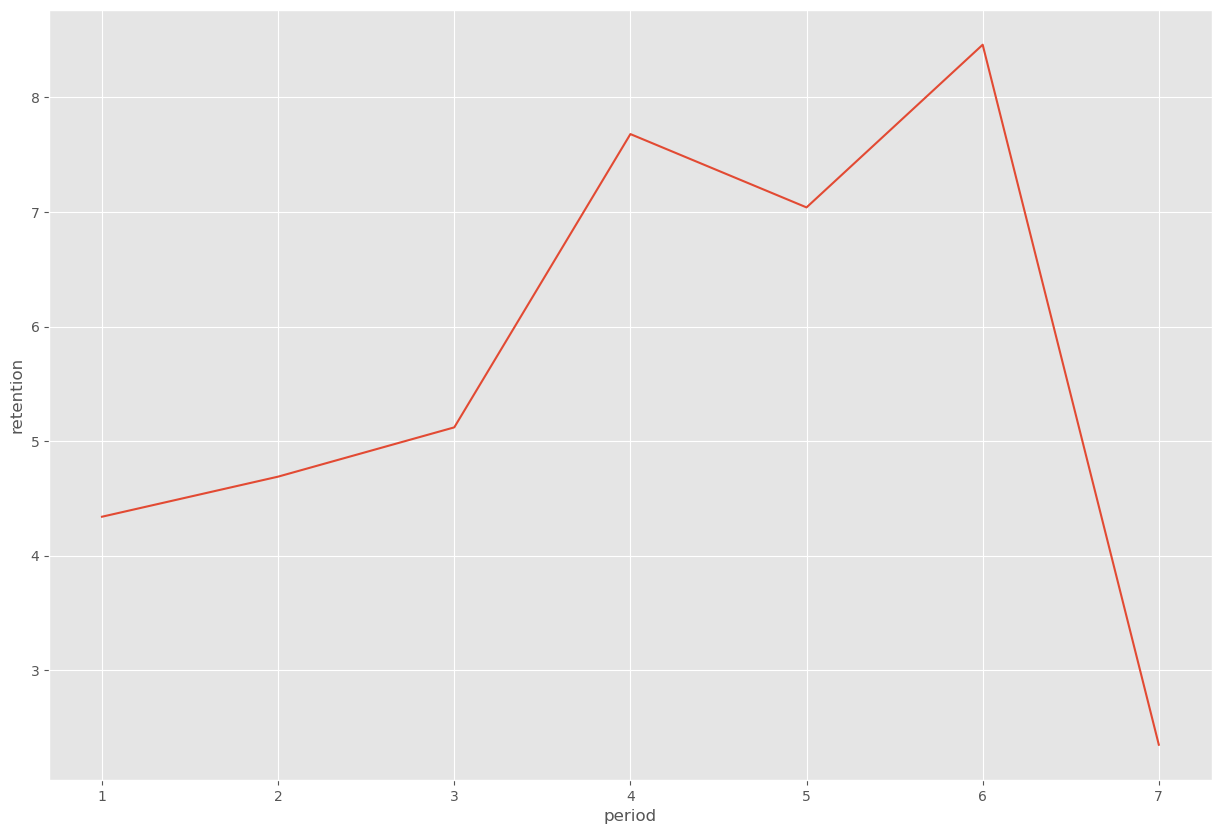

In [ ]:
window_retention_lineplot(df_window_result)

## Посмотрим на метрики акционных предложений

In [51]:
# посмотрим на данные
df = pd.read_csv('checks_a_b_test.csv', sep = ';')

In [ ]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [52]:
# более 404 тыс юзеров, пропусков в данных нет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [53]:
# юзеры практически равномерно распределены по тестовым группам
# группа b - тестовая
# группа a - контрольная
df.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

In [ ]:
# проверим на повторы айдишников
df.user_id.duplicated().sum()

0

In [ ]:
# из 404 тыс юзеров платящих (в обеих тестовых группах) только 3 733 человека
df[df.revenue > 0].groupby('testgroup', as_index = False) \
.agg({'revenue' : 'count'})

,testgroup,revenue
0,a,1928
1,b,1805


C:\Users\User\AppData\Local\Temp\ipykernel_6804\1408278990.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.query('testgroup == "a"')[df.revenue > 0].revenue.hist()


<AxesSubplot:>

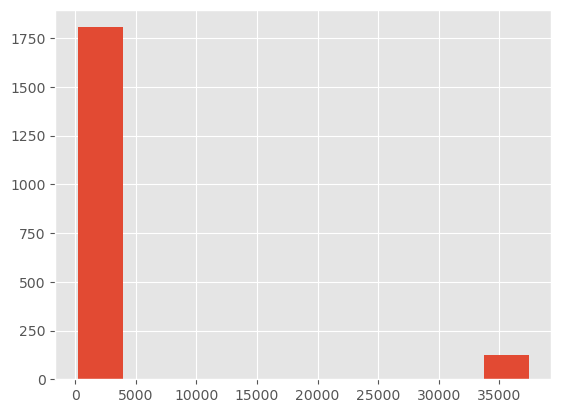

In [ ]:
# посмотрим на распределения чеков в группах
df.query('testgroup == "a"')[df.revenue > 0].revenue.hist()

C:\Users\User\AppData\Local\Temp\ipykernel_6804\3754818299.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.query('testgroup == "a"')[df.revenue > 30000].revenue.hist()


<AxesSubplot:>

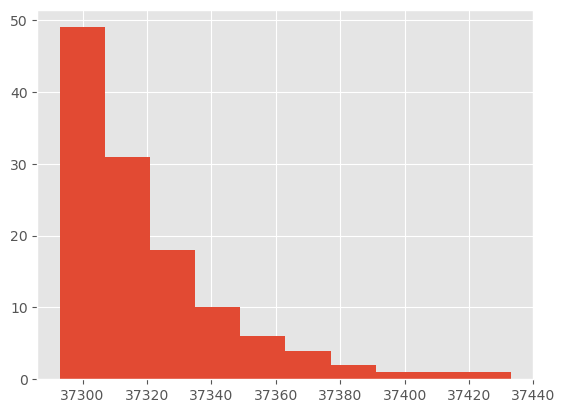

In [ ]:
# чеки 123 юзеров из контрольной группы очень большие в сравнении с остальными
df.query('testgroup == "a"')[df.revenue > 30000].revenue.hist()

In [ ]:
# а сколько заплатили эти 123 человека?
df.query('testgroup == "a"').revenue.count()

202103

C:\Users\User\AppData\Local\Temp\ipykernel_6804\1080178577.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.query('testgroup == "a"')[(df.revenue <=500)&(df.revenue > 0)].revenue.hist()


<AxesSubplot:>

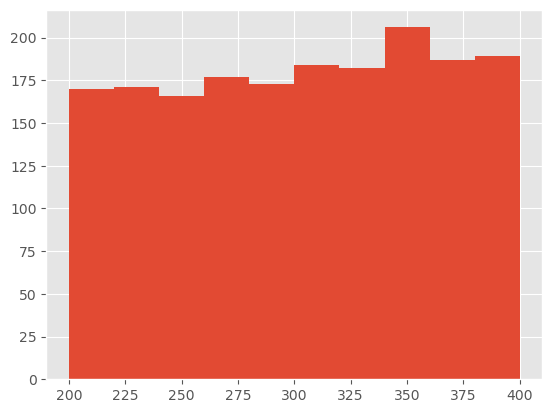

In [ ]:
# бОльшая часть контрольной группы платит более-менее одинаково
df.query('testgroup == "a"')[(df.revenue <=500)&(df.revenue > 0)].revenue.hist()

C:\Users\User\AppData\Local\Temp\ipykernel_6804\3496430426.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.query('testgroup == "b"')[df.revenue > 0].revenue.hist()


<AxesSubplot:>

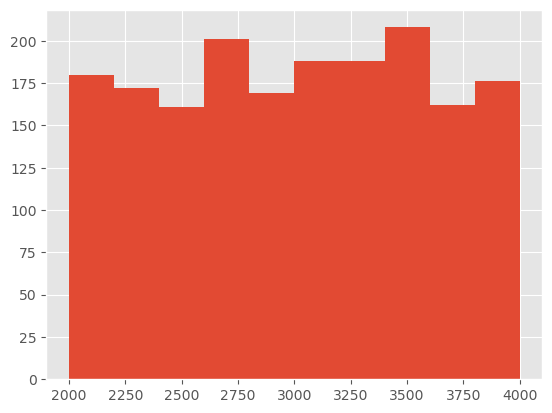

In [ ]:
# тестовая группа платит практически равномерно
df.query('testgroup == "b"')[df.revenue > 0].revenue.hist()

In [ ]:
# величина средних чеков платящих юзеров по группам
df.query('revenue > 0') \
.groupby('testgroup', as_index = False) \
.agg({'revenue' : 'mean'})

,testgroup,revenue
0,a,2663.998444
1,b,3003.658172


Итак, тестовая и контрольная группа примерно равны по общему количеству и по числу платящих пользователей. Однако распределения чеков экспериментальных групп совершенно разно выглядят:  
- в контрольной группе бОльшая часть юзеров платит как будто меньше, чем в среднем юзеры второй группы, при этом у распределения контрольных чеков имеется хвост из 123 юзеров (около 7% от всей группы), которые заплатили 89% всей суммы дохода от группы    
- в тестовой группе юзеры платят примерно одинаково, и в среднем побольше, чем в контрольной
Данная ситуация говорит о том, что просто ***необходимо рассмотреть систему сплитования***, с большой вероятностью она неоптимальна.

Далее проанализируем метрики с учетом / без учета "хвоста" контрольной группы, а именно возьмем распределения чеков в обеих группах и:  
1. **проверим на нормальность**,  
2. если они нормальны, **применим t-test**,  
3. иначе **применим бутстрап** для оценки CR / ARPU / ARPPU,   
4. **гипотеза Н0 - различий между группами нет, альтернативная гипотеза - они есть**, и средние чеки в группах значимо отличаются

### Расчет метрик с учетом "хвоста" оплат контрольной группы   
CR / ARPU / ARPPU

In [54]:
df['CR'] = df.revenue.apply(lambda x: 1 if x>0 else 0)
# общее число юзеров
users_total = df.groupby('testgroup', as_index = False) \
.agg({'user_id' : 'nunique'}) \
.rename(columns = {'user_id' : 'users_total'})

# число платящих юзеров
users_rev = df.query('revenue > 0') \
.groupby('testgroup', as_index = False) \
.agg({'user_id' : 'nunique'}) \
.rename(columns = {'user_id' : 'users_with_revenue'})

# общая сумма платежей всех юзеров
rev_total = df.groupby('testgroup', as_index = False) \
.agg({'revenue' : 'sum'}) \
.rename(columns = {'revenue' : 'rev_total'})

metrics = users_total.merge(rev_total, how = 'inner', on = 'testgroup') \
.merge(users_rev, how = 'inner', on = 'testgroup')

metrics['ARPU'] = metrics.rev_total / metrics.users_total
metrics['ARPPU'] = metrics.rev_total / metrics.users_with_revenue
metrics['CR'] = metrics.users_with_revenue*100/metrics.users_total

metrics

,testgroup,users_total,rev_total,users_with_revenue,ARPU,ARPPU,CR
0,a,202103,5136189,1928,25.413720,2663.998444,0.953969
1,b,202667,5421603,1805,26.751287,3003.658172,0.890624


### Проверка гипотез о стат значимом различии метрик

In [ ]:
# проверка на нормальность CR контрольной группы
stats.normaltest(df.query('testgroup == "a"').CR)

NormaltestResult(statistic=309937.129243099, pvalue=0.0)

In [ ]:
# проверка на нормальность ARPU контрольной группы
stats.normaltest(df.query('testgroup == "a"').revenue)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [ ]:
# проверка на нормальность ARPPU контрольной группы
stats.normaltest(df[(df.testgroup == "a")&(df.revenue > 0)].revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [ ]:
# проверка на нормальность CR тестовой группы
stats.normaltest(df.query('testgroup == "b"').CR)

NormaltestResult(statistic=317066.7733641729, pvalue=0.0)

In [ ]:
# проверка на нормальность ARPU тестовой группы
stats.normaltest(df.query('testgroup == "b"').revenue)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

In [ ]:
# проверка на нормальность ARPPU тестовой группы
stats.normaltest(df[(df.testgroup == "b")&(df.revenue > 0)].revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

Во всех случаях значения p-value меньше 0,05, гипотеза о нормальном распределении признаков во всех случаях отвергается: **оплаты пользователей ненормально распределены**  
Поэтому применим бутстрап:

In [55]:
# Объявим функцию, которая позволит проверять гипотезу о равенстве метрик
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_2),
            replace = True # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            len(data_column_2),
            replace = True
        ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"p_value": p_value,
            "quants": quants
           }

  0%|          | 0/1000 [00:00<?, ?it/s]

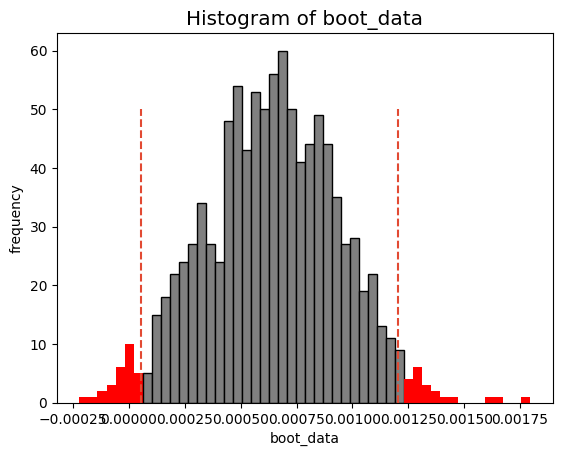

{'p_value': 0.03149719757245108,
 'quants':               0
 0.025  0.000054
 0.975  0.001204}

In [56]:
# посмотрим на бутстрэп по CR в покупку среди активных пользователей
# Н0: конверсии в тестовой и контрольной группе значимо не различаются
# Н1: конверсии теста и контроля значимо отличны
get_bootstrap(
    df[df.testgroup == 'a'].CR, # числовые значения первой выборки
    df[df.testgroup == 'b'].CR, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

  0%|          | 0/1000 [00:00<?, ?it/s]

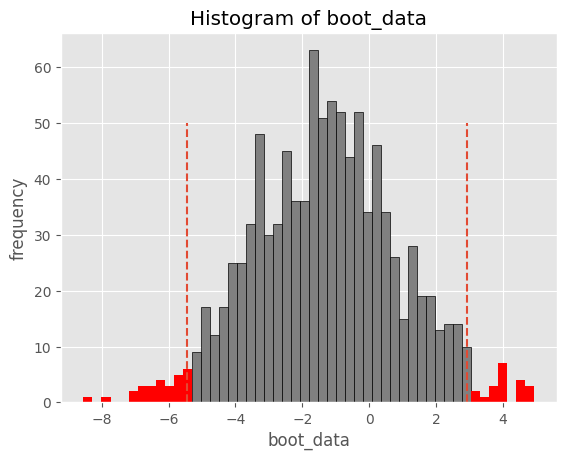

{'p_value': 0.5504074893609896,
 'quants':               0
 0.025 -5.445538
 0.975  2.933177}

In [57]:
# посмотрим на бутстрэп по ARPU
# Н0: средний чек юзера в тестовой и контрольной группе значимо не различаются
# Н1: средний чек юзера теста и контроля значимо отличны
get_bootstrap(
    df[df.testgroup == 'a'].revenue, # числовые значения первой выборки
    df[df.testgroup == 'b'].revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

  0%|          | 0/1000 [00:00<?, ?it/s]

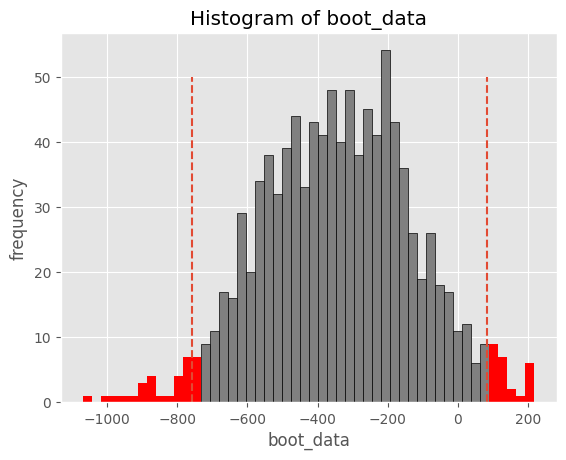

{'p_value': 0.1138046991985496,
 'quants':                 0
 0.025 -758.522050
 0.975   84.040291}

In [58]:
# посмотрим на бутстрэп по ARPPU
# Н0: средний чек платящего юзера в тестовой и контрольной группе значимо не различаются
# Н1: средний чек платящего юзера теста и контроля значимо отличны
get_bootstrap(
    df[(df.testgroup == 'a')&(df.revenue > 0)].revenue, # числовые значения первой выборки
    df[(df.testgroup == 'b')&(df.revenue > 0)].revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Итак, в результате анализа данных с учетом "хвоста" распределения чеков контрольной группы выяснилось:  
    - распределения оплат не являются нормальными,  
    - нет достаточных оснований утверждать, что метрики ARPU / ARPPU в группах значимо различны, в отличие от конверсии в покупку, у тестовой группы она значимо ниже.  

### Расчет метрик без учета "хвоста" оплат контрольной группы   
CR / ARPU / ARPPU

In [ ]:
df = df[df.revenue < 30000]

In [59]:
df['CR'] = df.revenue.apply(lambda x: 1 if x>0 else 0)
# общее число юзеров
users_total = df.groupby('testgroup', as_index = False) \
.agg({'user_id' : 'nunique'}) \
.rename(columns = {'user_id' : 'users_total'})

# число платящих юзеров
users_rev = df.query('revenue > 0') \
.groupby('testgroup', as_index = False) \
.agg({'user_id' : 'nunique'}) \
.rename(columns = {'user_id' : 'users_with_revenue'})

# общая сумма платежей всех юзеров
rev_total = df.groupby('testgroup', as_index = False) \
.agg({'revenue' : 'sum'}) \
.rename(columns = {'revenue' : 'rev_total'})

metrics = users_total.merge(rev_total, how = 'inner', on = 'testgroup') \
.merge(users_rev, how = 'inner', on = 'testgroup')

metrics['ARPU'] = metrics.rev_total / metrics.users_total
metrics['ARPPU'] = metrics.rev_total / metrics.users_with_revenue
metrics['CR'] = metrics.users_with_revenue*100/metrics.users_total

metrics

,testgroup,users_total,rev_total,users_with_revenue,ARPU,ARPPU,CR
0,a,202103,5136189,1928,25.413720,2663.998444,0.953969
1,b,202667,5421603,1805,26.751287,3003.658172,0.890624


Без учета больших чеков контрольной группы метрики тестовой группы выглядят привлекательнее

### Проверка гипотез о стат значимом различии метрик

In [ ]:
# проверка на нормальность CR контрольной группы
stats.normaltest(df.query('testgroup == "a"').CR)

NormaltestResult(statistic=315683.05098844616, pvalue=0.0)

In [ ]:
# проверка на нормальность ARPU контрольной группы
stats.normaltest(df.query('testgroup == "a"').revenue)

NormaltestResult(statistic=325234.0237587513, pvalue=0.0)

In [ ]:
# проверка на нормальность ARPPU контрольной группы
stats.normaltest(df[(df.testgroup == "a")&(df.revenue > 0)].revenue)

NormaltestResult(statistic=1341.2009917493335, pvalue=5.779697118077758e-292)

Тестовая группа при удалении "хвоста" не менялась, поэтому повторно проверять ее нет смысла. В контрольной группе также во всех случаях значения p-value меньше 0,05, гипотеза о нормальном распределении признаков во всех случаях отвергается: **оплаты пользователей ненормально распределены**  
Поэтому применим бутстрап:

  0%|          | 0/1000 [00:00<?, ?it/s]

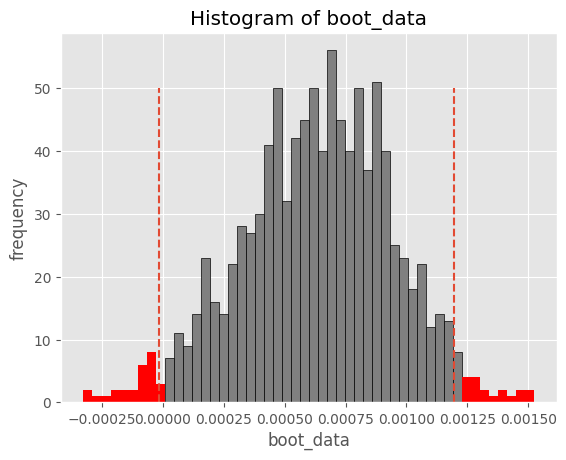

{'p_value': 0.03970561805483947,
 'quants':               0
 0.025 -0.000015
 0.975  0.001194}

In [61]:
# посмотрим на бутстрэп по CR в покупку среди активных пользователей
# Н0: конверсии в тестовой и контрольной группе значимо не различаются
# Н1: конверсии теста и контроля значимо отличны
get_bootstrap(
    df[df.testgroup == 'a'].CR, # числовые значения первой выборки
    df[df.testgroup == 'b'].CR, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

  0%|          | 0/1000 [00:00<?, ?it/s]

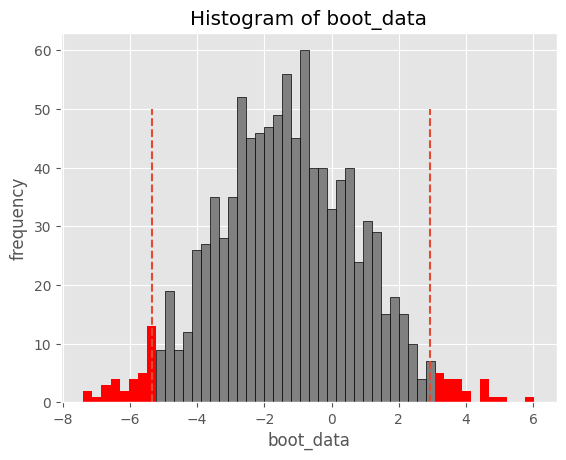

{'p_value': 0.5355478466407646,
 'quants':               0
 0.025 -5.355816
 0.975  2.928234}

In [62]:
# посмотрим на бутстрэп по ARPU
# Н0: средний чек юзера в тестовой и контрольной группе значимо не различаются
# Н1: средний чек юзера теста и контроля значимо отличны
get_bootstrap(
    df[df.testgroup == 'a'].revenue, # числовые значения первой выборки
    df[df.testgroup == 'b'].revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

  0%|          | 0/1000 [00:00<?, ?it/s]

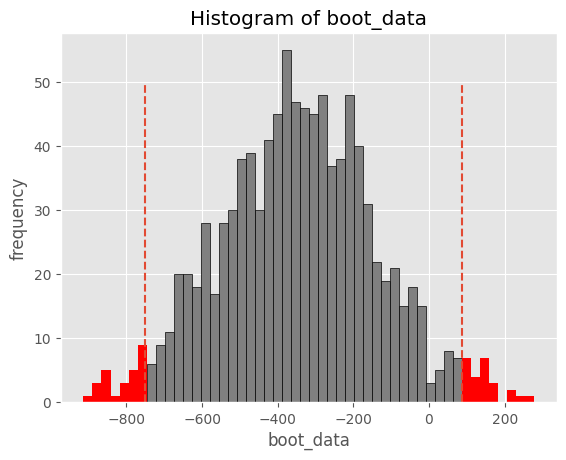

{'p_value': 0.09331227383360555,
 'quants':                 0
 0.025 -751.854806
 0.975   86.987562}

In [63]:
# посмотрим на бутстрэп по ARPPU
# Н0: средний чек платящего юзера в тестовой и контрольной группе значимо не различаются
# Н1: средний чек платящего юзера теста и контроля значимо отличны
get_bootstrap(
    df[(df.testgroup == 'a')&(df.revenue > 0)].revenue, # числовые значения первой выборки
    df[(df.testgroup == 'b')&(df.revenue > 0)].revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Итого:  
1. Тестовые группы примерно одинаковые по размерам,  
2. Распределения чеков в обеих группах не являются нормальными,  
3. В зависимости от подхода к данным (считать ли большие чеки контрольной группы выбросом) результаты получились разными:  
- при учете контрольных юзеров с большими чеками конверсия в покупку у тестовой группы снизилась, а метрики ARPU / ARPPU значимо не изменились,  
- если учитывать большие чеки как выбросы, то конверсия в обеих группах значимо не отличается, чего конечно же не скажешь о метриках ARPU / ARPPU, то есть оплата в тестовой группе значимо выросла и акционные изменения необходимо раскатывать.  
Однако прежде, чем принимать решение, **необходимо проверить систему сплитования** пользователей на группы, распределения чеков в группах вызывают вопросы.